In [1]:
print('This notebook references the following tutorials:')
print()
print(' * inferring in DV mode with spatial regularization')
print(' * inferring in stochastic DV mode with temporal regularization')
print(' * calculating Bayes factors on the forces inferred in D mode')
print(' * adjusting the mesh for Bayes factor calculation')
print()

This notebook references the following tutorials:

 * inferring in DV mode with spatial regularization
 * inferring in stochastic DV mode with temporal regularization
 * calculating Bayes factors on the forces inferred in D mode
 * adjusting the mesh for Bayes factor calculation



------------------------------------------------
Inferring in DV mode with spatial regularization
------------------------------------------------



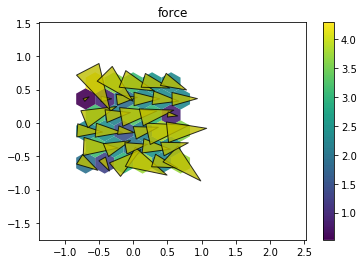

In [2]:
print('------------------------------------------------')
print('Inferring in DV mode with spatial regularization')
print('------------------------------------------------')
print()

## key parameters
# smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# localization error in um
localization_error = 0.01

## import
%matplotlib inline
from tramway.helper.inference import *
from tutorial import load_default_partition

## load the partition
cells = load_default_partition()

## infer
maps = infer(cells, 'DV',
        diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing,
        sigma=localization_error)

## plot the force
map_plot(maps, cells=cells, title='force', variable='force')
# other variables are 'diffusivity' and 'potential'

------------------------------------------------------------
Inferring in stochastic DV mode with temporal regularization
------------------------------------------------------------

you can interrupt the kernel (or hit Ctrl+C if not in a notebook) to stop the inference before convergence; maps will be generated anyway
segment: 0


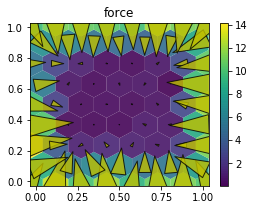

segment: 1


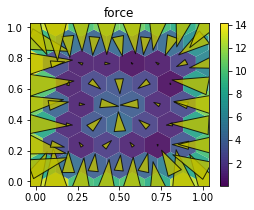

segment: 2


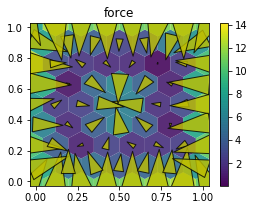

segment: 3


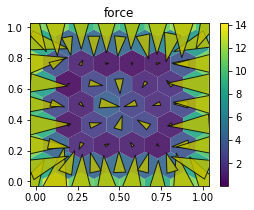

segment: 4


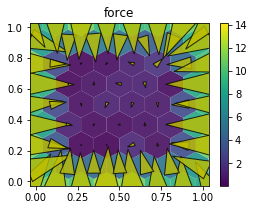

In [5]:
print('------------------------------------------------------------')
print('Inferring in stochastic DV mode with temporal regularization')
print('------------------------------------------------------------')
print()

## key parameters
# spatial smoothing parameters
diffusivity_smoothing = potential_smoothing = 1.
# temporal smoothing parameter
time_smoothing = 1.
# localization error in um
localization_error = 0.01

## import
%matplotlib inline
from tramway.helper.inference import *
from tramway.inference.time import *
from tutorial import load_default_partition

## load the partition
cells = load_default_partition(time_varying_properties=True)

## infer
print('you can interrupt the kernel (or hit Ctrl+C if not in a notebook) to stop the inference before convergence; maps will be generated anyway')
maps = infer(cells, 'stochastic.dv',
        new_cell=DynamicTranslocations, new_group=DynamicCells,
        diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing,
        time_prior=time_smoothing,
        sigma=localization_error)

## plot the force
print()
number_of_segments = len(cells.tessellation.time_lattice)
for segment in range(number_of_segments):
    
    print('segment: {}'.format(segment))
    map_plot(maps, cells, segment=segment, show=True, title='force', figsize=(4,3), variable='force')
    # other variables are 'diffusivity' and 'potential'


------------------------------------------------
Calculating Bayes factors on the inferred forces
------------------------------------------------



100%|██████████| 33/33 [00:00<00:00, 89.27it/s] 


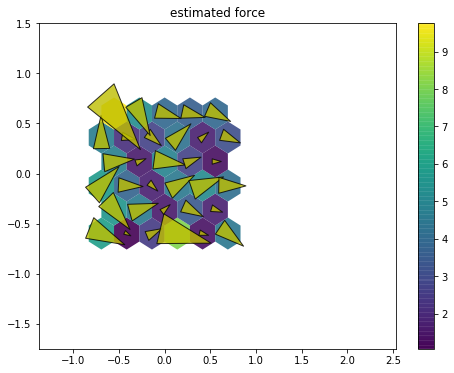

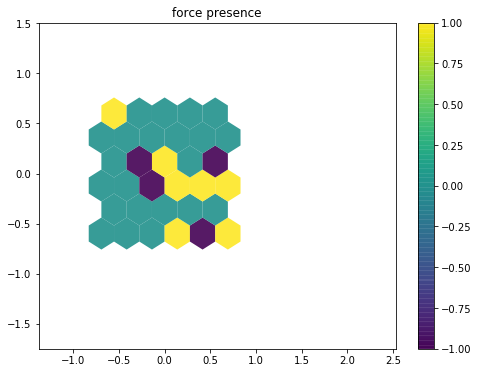

1= force; 0= not enough evidence; -1= no force


In [3]:
print('------------------------------------------------')
print('Calculating Bayes factors on the inferred forces')
print('------------------------------------------------')
print()

## key parameters
# localization error in um
localization_error = 0.01

# labels
partition_label = 'default' # do NOT modify
model_label = 'DF mode' # can be any integer or string value
bayes_factor_label = 'Bayes factors' # idem

## import
%matplotlib inline
from tramway.helper import *
from tutorial import load_default_tree

## load the analysis tree
analyses = load_default_tree()
# the structure is:
# --> default trajectories
#  +--> default partition
#    +--> (possibly) default maps

## infer
# DF mode
infer(analyses, 'df', sigma=localization_error,
     input_label=partition_label, output_label=model_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> DF-mode maps

# add SNR extensions required by the bayes_factor plugin
infer(analyses, 'snr', input_label=(partition_label, model_label), inplace=True)
# (the tree structure has not moved)

# Bayes factors
infer(analyses, 'bayes_factor', sigma=localization_error,
     input_label=(partition_label, model_label), output_label=bayes_factor_label)
# the structure now is:
# --> default trajectories
#  +--> default partition
#    +...
#    +--> DF+SNR maps
#      +--> Bayes factor maps

## plot the force detection map
figsize = (8,6)
map_plot(analyses, label=(partition_label, model_label), title='estimated force', variable='force', figsize=figsize, show=True)
map_plot(analyses, label=(partition_label, model_label, bayes_factor_label), title='force presence', variable='force', figsize=figsize, show=True)
print('1= force; 0= not enough evidence; -1= no force')

-----------------------------------------------
Adjusting the mesh for Bayes factor calculation
-----------------------------------------------

This notebook cell follows and requires the previous one.

The (naive) approach here consists of considering more locations per cell (or bin)
sampling as many nearest-neighbour locations as desired.

-------------------------------------------------------------------------------
minimum number of locations required to define whether
there is a force or not (as long as the variance does not change):


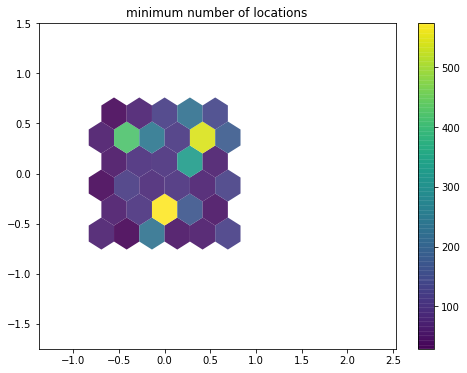


actual number of locations per cell:


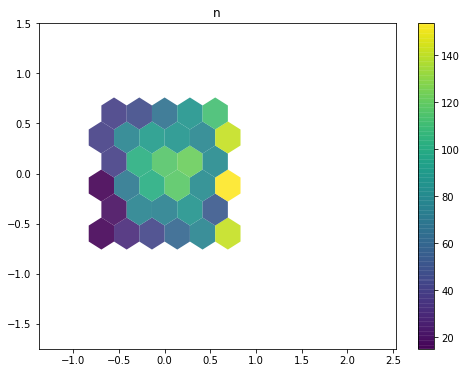

100%|██████████| 33/33 [00:00<00:00, 120.78it/s]



estimated force after increasing n:


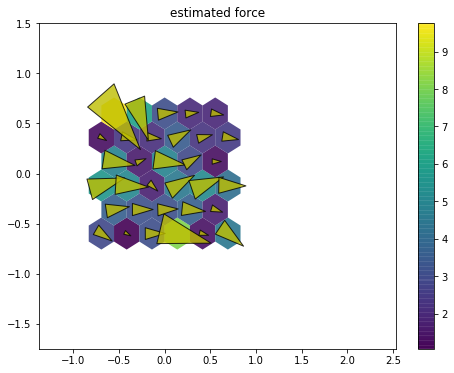

force presence:


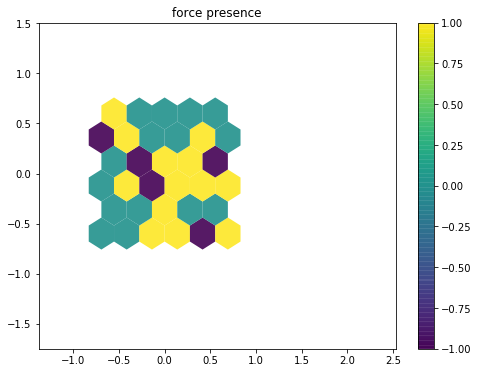

1= force; 0= not enough evidence; -1= no force

note that fewer results are undefined (fewer cells are 0);
not all the results are defined because the data variance has varied


In [4]:
print('-----------------------------------------------')
print('Adjusting the mesh for Bayes factor calculation')
print('-----------------------------------------------')
print()
print('This notebook cell follows and requires the previous one.')
print()
print('The (naive) approach here consists of considering more locations per cell (or bin)')
print('sampling as many nearest-neighbour locations as desired.')
print()

## plot the minimum number of locations required to determine whether there is a force or not
print('-------------------------------------------------------------------------------')
print('minimum number of locations required to define whether')
print('there is a force or not (as long as the variance does not change):') # in a notebook, figure titles sometimes miss
map_plot(analyses, label=(partition_label, model_label, bayes_factor_label), title='minimum number of locations', variable='min_n', figsize=figsize, show=True)
print()

## get the minimum number of locations per cell as a DataFrame
min_n = analyses[partition_label][model_label][bayes_factor_label].data['min_n'].astype(int)

## let us make a new partition
# copy the existing partition of the locations into cells (spatial bins)
import copy
previous_partition = analyses[partition_label].data
new_partition = copy.copy(previous_partition)

# reuse the tessellation to determine the cell indices for the locations,
# using the same parameters but 'knn' that we define as a function
# that takes a cell index and returns the corresponding minimum number of
# nearest locations (nearest to the cell center) AND maximum number, which
# we let undefined (None)
new_partition.cell_index = new_partition.tessellation.cell_index(new_partition.locations,
     knn=lambda i: (min_n.loc[i].values[0], None),
     **previous_partition.param.get('partition', {}))

# add the new partition to the analysis tree, as a direct child of the data root;
# this initiates a new branch
new_partition_label = partition_label + ' with overlap'
analyses[new_partition_label] = new_partition

## plot the actual number of locations per cell before we introduced 'knn'
print('actual number of locations per cell:')
map_plot(pd.DataFrame(previous_partition.location_count, columns=['n'], index=min_n.index), cells=previous_partition, figsize=figsize, show=True)

## infer again;
# note that we use new_partition_label and consequently do not overwrite anything
infer(analyses, 'df', sigma=localization_error,
     input_label=new_partition_label, output_label=model_label)
infer(analyses, 'snr', input_label=(new_partition_label, model_label), inplace=True)
infer(analyses, 'bayes_factor', sigma=localization_error,
     input_label=(new_partition_label, model_label), output_label=bayes_factor_label)

## plot the new force detection map
print() # bayes_factor is verbose
print('estimated force after increasing n:') # in a notebook, figure titles sometimes miss
map_plot(analyses, label=(new_partition_label, model_label), title='estimated force', variable='force', figsize=figsize, show=True)
print('force presence:') # in a notebook, figure titles sometimes miss
map_plot(analyses, label=(new_partition_label, model_label, bayes_factor_label), title='force presence', variable='force', figsize=figsize, show=True)
print('1= force; 0= not enough evidence; -1= no force')
print()
print('note that fewer results are undefined (fewer cells are 0);')
print('not all the results are defined because the data variance has varied')